In [1]:
# Base
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import skimage.metrics
import torch
import torchinfo
import torchvision

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Število slik:          800
Interval širine slik:  [1116, 2040]
Interval višine slik:  [648, 2040]
Povprečna širina slik: 1971.51 +- 203.28
Povprečna višina slik: 1435.17 +- 251.57


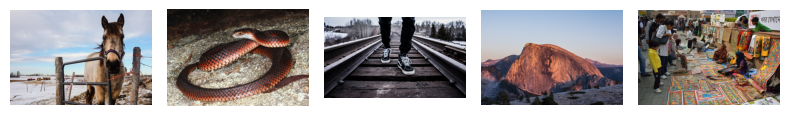

In [2]:
# DIV2K
path = "datasets/DIV2K/train/"

img_path_list = [os.path.join(path, name) for name in os.listdir(path)]

widths = []
heights = []
for img_path in img_path_list:
    with PIL.Image.open(img_path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

print(f"Število slik:          {len(img_path_list)}")
print(f"Interval širine slik:  [{np.min(widths)}, {np.max(widths)}]")
print(f"Interval višine slik:  [{np.min(heights)}, {np.max(heights)}]")
print(f"Povprečna širina slik: {np.mean(widths) :.2f} +- {np.std(widths) :.2f}")
print(f"Povprečna višina slik: {np.mean(heights) :.2f} +- {np.std(heights) :.2f}")

indices = np.random.default_rng().choice(len(img_path_list), 5, replace=False)

_, axes = plt.subplots(1, 5, figsize=(8, 3), squeeze=False)
for c in range(axes.shape[1]):
    img_path = img_path_list[indices[c]]
    with PIL.Image.open(img_path) as img:
        axes[0, c].imshow(img)
        axes[0, c].axis("off")
            
plt.tight_layout()

#### Generatorji slik

In [ ]:
from torch.utils import data

# Generator in nalaganje podatkovnih zbirk
from dataset import data_generator, load_dataset

# Argumenti
batch_size = 32
img_size = 256

# Učna podatkovna zbirka
train_dataset_imgs = load_dataset("datasets/DIV2K/train/")

train_dataset = data_generator(train_dataset_imgs, img_size, 1024)
train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True)

# Validacijska podatkovna zbirka
val_dataset_imgs = load_dataset("datasets/DIV2K/val/")

val_dataset = data_generator(val_dataset_imgs, img_size, 256)
val_data_loader = data.DataLoader(val_dataset, batch_size=1, pin_memory=True)

# Testna podatkovna zbirka
# TRAIN-TEST SPLIT!!
test_dataset_imgs = load_dataset("datasets/DIV2K/train/")

test_dataset = data_generator(test_dataset_imgs, img_size, 1000)
test_data_loader = data.DataLoader(test_dataset, batch_size=1, pin_memory=True)

#### Testiranje generiranja

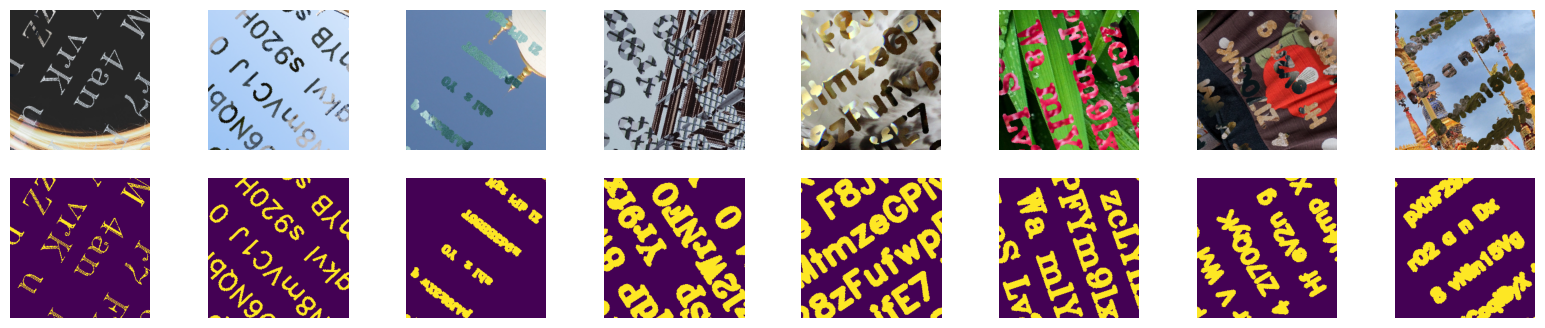

In [4]:
# Klic ene iteracije generatorja
inputs, labels = next(iter(train_data_loader))

_, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(0, 8):
    # Izris vhodov
    axes[0, i].imshow(torch.moveaxis(inputs[i], 0, 2))
    axes[0, i].axis("off")

    # Izris mask
    axes[1, i].imshow(torch.moveaxis(labels[i], 0, 2))
    axes[1, i].axis("off")

In [7]:
# Nevronska mreža
from neural_network import *

# Model
model = UNet(3, 1, 32, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.BCEWithLogitsLoss()
model_file_name = f"model_test.pt"

print(torchinfo.summary(model, (1, 3, img_size, img_size), depth=5))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 256, 256]          --
├─DownBlock: 1-1                              [1, 32, 128, 128]         --
│    └─Two_Conv2dBatchNorm2dReLU: 2-1         [1, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                       [1, 32, 256, 256]         864
│    │    └─BatchNorm2d: 3-2                  [1, 32, 256, 256]         64
│    │    └─Conv2d: 3-3                       [1, 32, 256, 256]         9,216
│    │    └─BatchNorm2d: 3-4                  [1, 32, 256, 256]         64
│    └─MaxPool2d: 2-2                         [1, 32, 128, 128]         --
├─DownBlock: 1-2                              [1, 64, 64, 64]           --
│    └─Two_Conv2dBatchNorm2dReLU: 2-3         [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-5                       [1, 64, 128, 128]         18,432
│    │    └─BatchNorm2d: 3-6                  [1, 64, 128, 128]         128
│    │    └

In [8]:
# Učenje
epochs = 10

# Beleženje zgodovine
history = {"train_loss": [], "val_loss": []}

model.to(device)
nn_train(model, train_data_loader, val_data_loader, epochs, optimizer, loss_fn, history)

# Shranjevanje modela
torch.save(model, model_file_name)

Epoch: [1/10] | Train Loss: 0.7181 | Val Loss: 0.7105 | LR: 0.000010
Epoch: [2/10] | Train Loss: 0.7013 | Val Loss: 0.6925 | LR: 0.000010
Epoch: [3/10] | Train Loss: 0.6903 | Val Loss: 0.6847 | LR: 0.000010
Epoch: [4/10] | Train Loss: 0.6776 | Val Loss: 0.6832 | LR: 0.000010
Epoch: [5/10] | Train Loss: 0.6645 | Val Loss: 0.6544 | LR: 0.000010
Epoch: [6/10] | Train Loss: 0.6506 | Val Loss: 0.6368 | LR: 0.000010
Epoch: [7/10] | Train Loss: 0.6336 | Val Loss: 0.6235 | LR: 0.000010
Epoch: [8/10] | Train Loss: 0.6164 | Val Loss: 0.6152 | LR: 0.000010
Epoch: [9/10] | Train Loss: 0.6035 | Val Loss: 0.5935 | LR: 0.000010
Epoch: [10/10] | Train Loss: 0.5906 | Val Loss: 0.5760 | LR: 0.000010


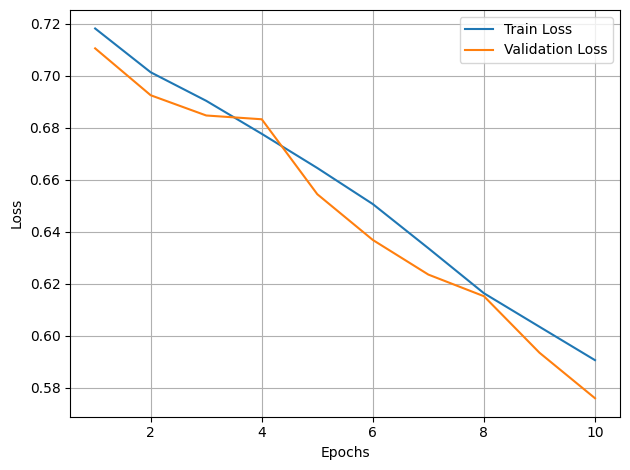

In [14]:
# Kako se je model učil
epochs = range(1, len(history["train_loss"]) + 1)

# Izguba
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Testiranje

IoU 300:  0.46
Dice 300: 0.52
IoU 880:  0.50
Dice 880: 0.58
IoU 1000:  0.88
Dice 1000: 0.94


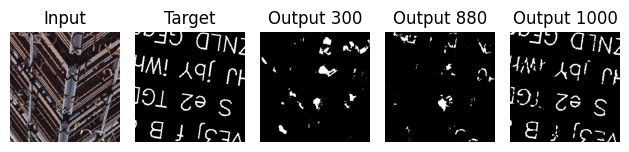

IoU 300:  0.56
Dice 300: 0.68
IoU 880:  0.68
Dice 880: 0.80
IoU 1000:  0.95
Dice 1000: 0.97


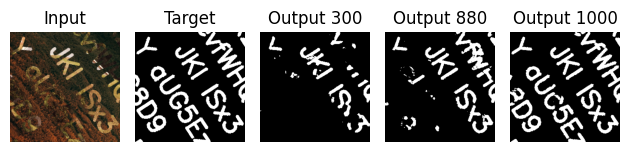

IoU 300:  0.89
Dice 300: 0.94
IoU 880:  0.94
Dice 880: 0.97
IoU 1000:  0.99
Dice 1000: 1.00


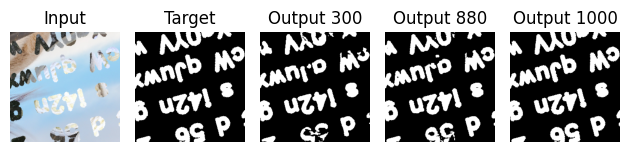

IoU 300:  0.72
Dice 300: 0.82
IoU 880:  0.79
Dice 880: 0.87
IoU 1000:  0.95
Dice 1000: 0.97


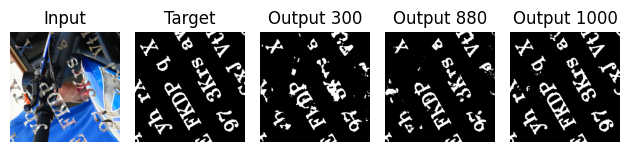

IoU 300:  0.86
Dice 300: 0.92
IoU 880:  0.94
Dice 880: 0.97
IoU 1000:  0.99
Dice 1000: 1.00


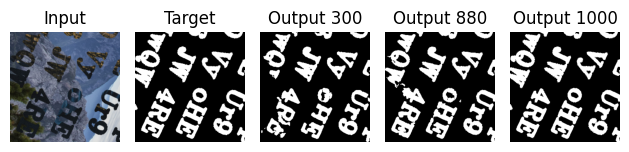

IoU 300:  0.85
Dice 300: 0.92
IoU 880:  0.93
Dice 880: 0.96
IoU 1000:  0.99
Dice 1000: 0.99


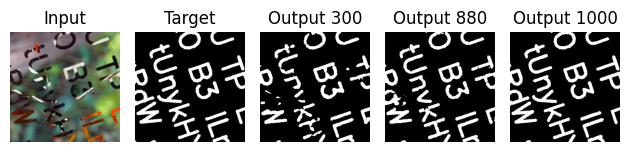

IoU 300:  0.70
Dice 300: 0.79
IoU 880:  0.79
Dice 880: 0.87
IoU 1000:  0.96
Dice 1000: 0.98


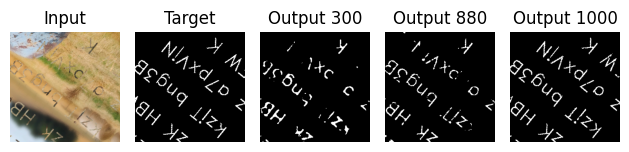

IoU 300:  0.96
Dice 300: 0.98
IoU 880:  0.99
Dice 880: 0.99
IoU 1000:  1.00
Dice 1000: 1.00


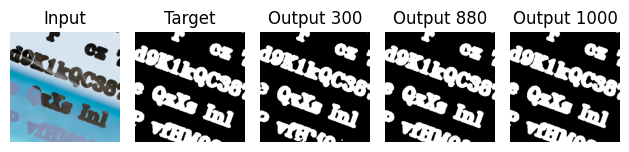

In [3]:
from helper import calculate_dice_coeff, calculate_iou

# CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testiranje naučenega modela
model_1000 = torch.load("model_1000.pt", weights_only=False)
model_1000.to(device)
model_1000.eval()

model_880 = torch.load("model_880.pt", weights_only=False)
model_880.to(device)
model_880.eval()

model_300 = torch.load("model_300.pt", weights_only=False)
model_300.to(device)
model_300.eval()

for i, data in enumerate(test_data_loader):
    input, target = data
    input = input.to(device)
    target = target.to(device)

    # Predikcija z NM - 1000 epoh
    with torch.no_grad():
        output_1000 = model_1000(input)
        output_1000 = torch.sigmoid(output_1000).round()
        output_1000 = output_1000.detach()

    # Predikcija z NM - 880 epoh
    with torch.no_grad():
        output_880 = model_880(input)
        output_880 = torch.sigmoid(output_880).round()
        output_880 = output_880.detach()

    # Predikcija z NM - 300 epoh
    with torch.no_grad():
        output_300 = model_300(input)
        output_300 = torch.sigmoid(output_300).round()
        output_300 = output_300.detach()

    # Izračun metrik
    print(f"IoU 300:  {calculate_iou(output_300, target):.2f}")
    print(f"Dice 300: {calculate_dice_coeff(output_300, target):.2f}")

    print(f"IoU 880:  {calculate_iou(output_880, target):.2f}")
    print(f"Dice 880: {calculate_dice_coeff(output_880, target):.2f}")

    print(f"IoU 1000:  {calculate_iou(output_1000, target):.2f}")
    print(f"Dice 1000: {calculate_dice_coeff(output_1000, target):.2f}")

    # Permutacija dimenzij
    input = input.squeeze(0).permute(1, 2, 0)
    target = target.squeeze(0).permute(1, 2, 0)
    output_300 = output_300.squeeze(0).permute(1, 2, 0)
    output_880 = output_880.squeeze(0).permute(1, 2, 0)
    output_1000 = output_1000.squeeze(0).permute(1, 2, 0)

    _, axes = plt.subplots(1, 5, squeeze=False)

    axes[0, 0].imshow(input.to('cpu'))
    axes[0, 0].set_title("Input")
    axes[0, 0].axis("off")
    axes[0, 1].imshow(target.to('cpu'), cmap="gray")
    axes[0, 1].set_title("Target")
    axes[0, 1].axis("off")
    axes[0, 2].imshow(output_300.to('cpu'), cmap="gray")
    axes[0, 2].set_title("Output 300")
    axes[0, 2].axis("off")
    axes[0, 3].imshow(output_880.to('cpu'), cmap="gray")
    axes[0, 3].set_title("Output 880")
    axes[0, 3].axis("off")
    axes[0, 4].imshow(output_1000.to('cpu'), cmap="gray")
    axes[0, 4].set_title("Output 1000")
    axes[0, 4].axis("off")

    plt.tight_layout()
    plt.show()

#### Rezultat za 1000 generiranih slik

In [ ]:
iou_list = []
dice_list = []

# Testiranje naučenega modela - map_location cpu ni dobra izbira, če je na voljo CUDA
model = torch.load("model_300.pt", weights_only=False)
model.to(device)
model.eval()

for input, target in test_data_loader:
    # Predikcija z NM
    with torch.no_grad():
        output = model(input.to(device))
        output = torch.sigmoid(output).round()
        output = output.detach().to('cpu')

    iou_list.append(calculate_iou(output, target))
    dice_list.append(calculate_dice_coeff(output, target))

print(f"IoU (povprečje +- standardni odklon):  {np.mean(iou_list) :.2f} +- {np.std(iou_list) :.2f}")
print(f"Dice (povprečje +- standardni odklon): {np.mean(dice_list) :.2f} +- {np.std(dice_list) :.2f}")

In [ ]:
iou_list = []
dice_list = []

model = torch.load("model_1000.pt", weights_only=False)
model.to(device)
model.eval()

for input, target in test_data_loader:
    # Predikcija z NM
    with torch.no_grad():
        output = model(input.to(device))
        output = torch.sigmoid(output).round()
        output = output.detach().to('cpu')

    iou_list.append(calculate_iou(output, target))
    dice_list.append(calculate_dice_coeff(output, target))

print(f"IoU (povprečje +- standardni odklon):  {np.mean(iou_list) :.2f} +- {np.std(iou_list) :.2f}")
print(f"Dice (povprečje +- standardni odklon): {np.mean(dice_list) :.2f} +- {np.std(dice_list) :.2f}")

#### Testiranje na realnih slikah

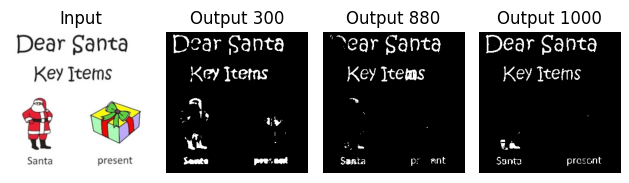

In [4]:
from PIL import Image

img = Image.open("datasets/custom/test/santa_2.png")
img = np.array(img, dtype=np.float32)[:, :, 0:3] / 255.

input = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
input = input.to(device)

# Predikcija z NM - 1000 epoh
with torch.no_grad():
    output_1000 = model_1000(input)
    output_1000 = torch.sigmoid(output_1000).round()
    output_1000 = output_1000.detach().to('cpu')

# Predikcija z NM - 880 epoh
with torch.no_grad():
    output_880 = model_880(input)
    output_880 = torch.sigmoid(output_880).round()
    output_880 = output_880.detach().to('cpu')

# Predikcija z NM - 300 epoh
with torch.no_grad():
    output_300 = model_300(input)
    output_300 = torch.sigmoid(output_300).round()
    output_300 = output_300.detach().to('cpu')

input = input.squeeze(0).permute(1, 2, 0)
output_300 = output_300.squeeze(0).permute(1, 2, 0)
output_880 = output_880.squeeze(0).permute(1, 2, 0)
output_1000 = output_1000.squeeze(0).permute(1, 2, 0)

_, axes = plt.subplots(1, 4, squeeze=False)

axes[0, 0].imshow(input.to('cpu'))
axes[0, 0].axis("off")
axes[0, 0].set_title("Input")
axes[0, 1].imshow(output_300, cmap="gray")
axes[0, 1].axis("off")
axes[0, 1].set_title("Output 300")
axes[0, 2].imshow(output_880, cmap="gray")
axes[0, 2].axis("off")
axes[0, 2].set_title("Output 880")
axes[0, 3].imshow(output_1000, cmap="gray")
axes[0, 3].axis("off")
axes[0, 3].set_title("Output 1000")

plt.tight_layout()